In [12]:
cd ../src

/Users/dani/Google Drive/Uni/Master/P4 2021/DD2424 - Deep Learning for Data Science/Project/ScarceClassifier/src


In [13]:
from d07_visualization.viz_training import plot_acc, plot_training_loss, plot_losses
from d04_mixmatch.wideresnet import WideResNet
from d02_data.load_data import get_dataloaders_ssl
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [16]:
model_name = '250_lbl_unlearns.pt'
saved_model = torch.load(f'../models/saved_models/{model_name}', map_location=torch.device('cpu')) 

model = WideResNet(depth=28, k=2, n_out=10, bias=True)
model.load_state_dict(saved_model['model_state_dict'])

# optim = ...
# optim.load_state_dict(saved_model['optimizer_state_dict'])

loss_train = saved_model['loss_train']
loss_val = saved_model['loss_val']
acc_train = saved_model['acc_train']
acc_val = saved_model['acc_val']


In [17]:
loss_batch = saved_model['loss_batch']
lx = saved_model['lx']
lu = saved_model['lu']
lu_weighted = saved_model['lu_weighted']

In [18]:
saved_model.keys()

dict_keys(['step', 'model_state_dict', 'ema_state_dict', 'optimizer_state_dict', 'loss_train', 'loss_val', 'acc_train', 'acc_val', 'loss_batch', 'lx', 'lu', 'lu_weighted', 'steps', 'batch_size', 'num_labels', 'lambda_u_max', 'step_top_up', 'lr', 'weight_decay', 'momentum', 'lr_decay', 'lbl_idx', 'unlbl_idx', 'val_idx'])

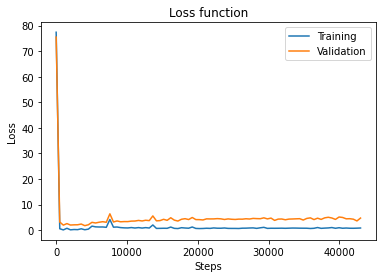

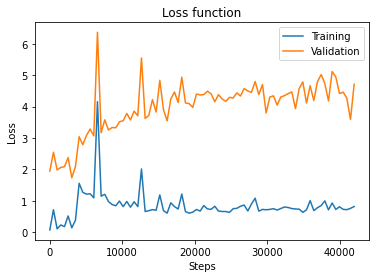

In [19]:
plot_training_loss(loss_train, loss_val, step=500)
plt.show()
plot_training_loss(loss_train[2:], loss_val[2:], step=500)


Max val acc: 52.16


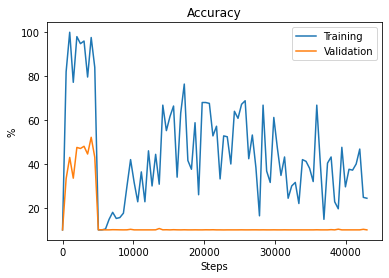

In [20]:
print('Max val acc: ' + str(max(acc_val)))
plot_acc(acc_train, acc_val, step=500)


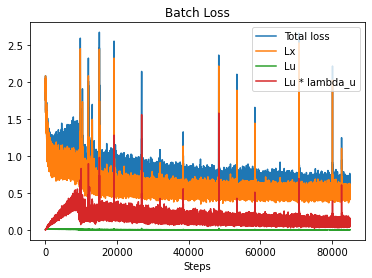

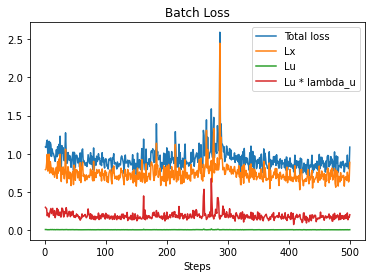

In [24]:
plot_losses(loss_batch[50:], lx[50:], lu[50:], lu_weighted[50:])
plt.show()
plot_losses(loss_batch[9500:10000], lx[9500:10000], lu[9500:10000], lu_weighted[9500:10000])

In [19]:
def evaluate(dataloader):
    criterion = nn.CrossEntropyLoss()
    model.eval()
    correct, total, loss = 0, 0, 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data[0], data[1]
            outputs = model(inputs)
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = correct / total * 100
    return loss, acc

_, _, _, test_loader = get_dataloaders_ssl(path='../data', batch_size=64, num_labeled=250)
test_val, test_acc = evaluate(test_loader)
print("Test accuracy: %.3f" % (test_acc))

Files already downloaded and verified
Files already downloaded and verified
Test accuracy: 35.220


In [11]:
loss_list = []
for i in range(10):
    loss_list.append(round(np.mean(lu[i*1000:(i+1)*1000]),3))
print(loss_list)

[0.01, 0.013, 0.011, 0.008, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004]
